# Setup Forecasting Analysis

#### Matthew Fernadnez
##### 8/21/25
Data Creation, Data Cleaning, Feature Engineering, and Data Exploration all in this notebook. Data Creation is taken as a best estimator of the real-world data.

This projects goal is to forecast when a particular container needs to be serviced. 
<br>There are two ML models answering these questions:
<br>1. How many weeks out will a container need to be serviced?
<br>2. Will a container need to be serviced next week?


In [0]:
import sys
import os
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, average_precision_score, classification_report

import matplotlib.pyplot as plt

import mlflow
mlflow.set_tracking_uri("databricks")
mlflow.set_experiment("/Shared/bin-cleaning-classifier")


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f8a4258cf40>
Traceback (most recent call last):
  File "/databricks/python/lib/python3.12/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/databricks/python/lib/python3.12/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/databricks/python/lib/python3.12/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
                   ^^^^^^^^^^^^^^^^^^
  File "/databricks/python/lib/python3.12/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
             ^^^^^^^^^^^^^^^^^^
AttributeError: 'NoneType' object has no attribute 'split'


<Experiment: artifact_location='dbfs:/databricks/mlflow-tracking/927145935820204', creation_time=1757487594510, experiment_id='927145935820204', last_update_time=1757488794755, lifecycle_stage='active', name='/Shared/bin-cleaning-classifier', tags={'mlflow.experiment.sourceName': '/Shared/bin-cleaning-classifier',
 'mlflow.experimentType': 'MLFLOW_EXPERIMENT',
 'mlflow.ownerEmail': 'matthew89fernandez@gmail.com',
 'mlflow.ownerId': '72453478617777'}>

In [0]:
np.random.seed(42)

## Data Creation
Create synthetic dates for every 7th day across 7 years

In [0]:
## Create Synthetic dates
years = 7
start_date = datetime.now() - timedelta(days=years*365)

end_date = datetime.now()
num_dates = 52 * years
weeks = np.arange(1, num_dates + 1)

random_dates = [start_date + timedelta(weeks=i, days=np.random.randint(0, 7)) for i in range(num_dates)]
(pd.DataFrame({'random_date': random_dates})).head()

,random_date
0,2018-09-18 15:41:39.633316
1,2018-09-22 15:41:39.633316
2,2018-09-30 15:41:39.633316
3,2018-10-09 15:41:39.633316
4,2018-10-12 15:41:39.633316


In [0]:
container_types = ['S14A+', 'CT22', 'P32A+', 'R64', 'S22A+', 'P22', 'S32', 'P14', 'CT64', 'S32A+', 'P64']

Container class as a helper function to create mock real-world data for container types

In [0]:

class Container():
    

    def __init__(self, container_type, max_reuses, base_rate, season_amp, jitter_max, spike_count, spike_min, spike_max):
        """
        ## DEFAULT knobs
        base_rate = 0.1            # baseline weekly fill increment (~20%)
        season_amp = 0.25            # seasonality effect on the increment
        jitter_max = 0.15            # up to +10% extra noise on the increment (never negative)
        spike_count = 12
        spike_min, spike_max = 0.30, 0.60
        """
        self.container_type = container_type
        self.rng = np.random.default_rng(7)
        self.n_weeks = 52 * years
        self.threshold = 0.80
        self.max_reuses = max_reuses
        self.base_rate = base_rate
        self.season_amp = season_amp
        self.jitter_max = jitter_max
        self.spike_count = spike_count
        self.spike_min = spike_min
        self.spike_max = spike_max


    
    def create_levels(self):
        """
        Create the Levels and Reuses synthetic data
        """

        weeks = np.arange(self.n_weeks)
        seasonal = 1.0 + self.season_amp * np.sin(2*np.pi*weeks/52.0)

        # raw (positive) increment proposal each week
        inc_raw = self.base_rate * seasonal * (1.0 + self.rng.uniform(0.0, self.jitter_max, size=self.n_weeks))


        levels = np.zeros(self.n_weeks, dtype=float)
        increments = np.zeros(self.n_weeks, dtype=float)
        cleaned = np.zeros(self.n_weeks, dtype=bool)

        fill = 0.0
        last_inc = 0.0         # ensures non-decreasing increments within a run
        reset_next = False

        for t in range(self.n_weeks):
            # apply reset (clean) at the start of the week if flagged
            if reset_next:
                fill = 0.0
                last_inc = 0.0     # restart monotonic sequence after a clean
                reset_next = False
                cleaned[t] = True

            # enforce non-decreasing increment
            inc = max(inc_raw[t], last_inc)


            # update and store
            fill = min(1.0, fill + inc)
            levels[t] = fill
            increments[t] = inc
            last_inc = inc

            # schedule cleaning next week if threshold reached
            if fill >= self.threshold:
                reset_next = True
            
        levels = np.round(levels, decimals=2)

        # Reuses each container has w/r to date
        reuses = np.zeros([levels.size])
        dead_container_bool = np.zeros([levels.size], dtype=bool)
        for idx,i in enumerate(reuses[1:]):
            if reuses[idx-1] >= self.max_reuses:
                dead_container_bool[idx] =  True
                reuses[idx] = np.nan
            elif levels[idx-1] >= self.threshold:
                if dead_container_bool[idx-1] != True:
                    dead_container_bool[idx] =  False
                    reuses[idx] = int(reuses[idx-1]+1)
            else:
                if dead_container_bool[idx-1] != True:
                    dead_container_bool[idx] = False
                    reuses[idx] = int(reuses[idx-1])
        return levels, reuses

Create the containers with some added randomness to best reflect mock real-world data. Store all containers in a pandas DataFrame. 

In [0]:
# Init empty DF
df_original = pd.DataFrame({"date": random_dates})

# Save all containers objects
stored_containers_dict = {}

for loc in ['E.1.1','E.1.2', 'C.1.1', 'C.1.3']:
    for name in container_types:
        max_reuses = np.random.choice([15, 20, 25, 30])
        base_rate = np.random.choice([0.05, 0.1, 0.13, 0.15])
        season_amp = np.random.choice([0.2, 0.22, 0.24, 0.26])
        jitter_max = np.random.choice([0.11, 0.13, 0.15])
        spike_count = np.random.choice([5, 8, 9, 10, 12])
        spike_min = np.random.choice([0.26, 0.28, 0.3, 0.32])
        spike_max = np.random.choice([0.25, 0.3, 0.4, 0.55])
        container_name = f"{name}_{loc}"
        container_tmp = Container(container_name, max_reuses=max_reuses, base_rate=base_rate, season_amp=season_amp, jitter_max=jitter_max, spike_count=spike_count, spike_min=spike_min, spike_max=spike_max)

        stored_containers_dict[container_name] = container_tmp # Store the containers and its attributes for each type of container

        levels, reuses = container_tmp.create_levels()

        # Store the fill_level and reuses counts for each container in a pd.DataFrame
        df_original[f"{container_name}_fill_level"] = levels
        df_original[f"{container_name}_reuses"] = reuses


## Data Exploration

In [0]:
df_original = df_original.iloc[:-1]
df_original.head()

,date,S14A+_E.1.1_fill_level,S14A+_E.1.1_reuses,CT22_E.1.1_fill_level,CT22_E.1.1_reuses,P32A+_E.1.1_fill_level,P32A+_E.1.1_reuses,R64_E.1.1_fill_level,R64_E.1.1_reuses,S22A+_E.1.1_fill_level,S22A+_E.1.1_reuses,P22_E.1.1_fill_level,P22_E.1.1_reuses,S32_E.1.1_fill_level,S32_E.1.1_reuses,P14_E.1.1_fill_level,P14_E.1.1_reuses,CT64_E.1.1_fill_level,CT64_E.1.1_reuses,S32A+_E.1.1_fill_level,S32A+_E.1.1_reuses,P64_E.1.1_fill_level,P64_E.1.1_reuses,S14A+_E.1.2_fill_level,S14A+_E.1.2_reuses,CT22_E.1.2_fill_level,CT22_E.1.2_reuses,P32A+_E.1.2_fill_level,P32A+_E.1.2_reuses,R64_E.1.2_fill_level,R64_E.1.2_reuses,S22A+_E.1.2_fill_level,S22A+_E.1.2_reuses,P22_E.1.2_fill_level,P22_E.1.2_reuses,S32_E.1.2_fill_level,S32_E.1.2_reuses,P14_E.1.2_fill_level,P14_E.1.2_reuses,CT64_E.1.2_fill_level,...,P32A+_C.1.1_fill_level,P32A+_C.1.1_reuses,R64_C.1.1_fill_level,R64_C.1.1_reuses,S22A+_C.1.1_fill_level,S22A+_C.1.1_reuses,P22_C.1.1_fill_level,P22_C.1.1_reuses,S32_C.1.1_fill_level,S32_C.1.1_reuses,P14_C.1.1_fill_level,P14_C.1.1_reuses,CT64_C.1.1_fill_level,CT64_C.1.1_reuses,S32A+_C.1.1_fill_level,S32A+_C.1.1_reuses,P64_C.1.1_fill_level,P64_C.1.1_reuses,S14A+_C.1.3_fill_level,S14A+_C.1.3_reuses,CT22_C.1.3_fill_level,CT22_C.1.3_reuses,P32A+_C.1.3_fill_level,P32A+_C.1.3_reuses,R64_C.1.3_fill_level,R64_C.1.3_reuses,S22A+_C.1.3_fill_level,S22A+_C.1.3_reuses,P22_C.1.3_fill_level,P22_C.1.3_reuses,S32_C.1.3_fill_level,S32_C.1.3_reuses,P14_C.1.3_fill_level,P14_C.1.3_reuses,CT64_C.1.3_fill_level,CT64_C.1.3_reuses,S32A+_C.1.3_fill_level,S32A+_C.1.3_reuses,P64_C.1.3_fill_level,P64_C.1.3_reuses
0,2018-09-18 15:41:39.633316,0.16,0.0,0.11,0.0,0.16,0.0,0.11,0.0,0.14,0.0,0.14,0.0,0.14,0.0,0.16,0.0,0.05,0.0,0.14,0.0,0.16,0.0,0.11,0.0,0.16,0.0,0.11,0.0,0.16,0.0,0.11,1.0,0.16,0.0,0.16,0.0,0.11,0.0,0.16,...,0.11,0.0,0.05,0.0,0.14,0.0,0.05,0.0,0.14,0.0,0.05,0.0,0.16,0.0,0.16,0.0,0.11,0.0,0.14,0.0,0.16,0.0,0.16,0.0,0.05,0.0,0.05,0.0,0.16,0.0,0.14,0.0,0.11,0.0,0.16,0.0,0.16,0.0,0.11,1.0
1,2018-09-22 15:41:39.633316,0.33,0.0,0.23,0.0,0.34,0.0,0.22,0.0,0.29,0.0,0.29,0.0,0.29,0.0,0.33,0.0,0.11,0.0,0.29,0.0,0.33,0.0,0.22,0.0,0.34,0.0,0.22,0.0,0.33,0.0,0.22,1.0,0.33,0.0,0.33,0.0,0.22,0.0,0.33,...,0.22,0.0,0.11,0.0,0.29,0.0,0.11,0.0,0.29,0.0,0.11,0.0,0.33,0.0,0.33,0.0,0.22,0.0,0.29,0.0,0.34,0.0,0.33,0.0,0.11,0.0,0.11,0.0,0.33,0.0,0.29,0.0,0.22,0.0,0.33,0.0,0.33,0.0,0.22,1.0
2,2018-09-30 15:41:39.633316,0.50,0.0,0.34,0.0,0.52,0.0,0.34,0.0,0.44,0.0,0.44,0.0,0.45,0.0,0.50,0.0,0.17,0.0,0.44,0.0,0.50,0.0,0.34,0.0,0.52,0.0,0.33,0.0,0.50,0.0,0.33,1.0,0.50,0.0,0.51,0.0,0.34,0.0,0.51,...,0.34,0.0,0.17,0.0,0.44,0.0,0.17,0.0,0.44,0.0,0.17,0.0,0.51,0.0,0.51,0.0,0.34,0.0,0.43,0.0,0.52,0.0,0.51,0.0,0.17,0.0,0.17,0.0,0.51,0.0,0.44,0.0,0.34,0.0,0.50,0.0,0.50,0.0,0.33,1.0
3,2018-10-09 15:41:39.633316,0.67,0.0,0.46,0.0,0.70,0.0,0.45,0.0,0.59,0.0,0.59,0.0,0.60,0.0,0.67,0.0,0.22,0.0,0.59,0.0,0.67,0.0,0.46,0.0,0.69,0.0,0.45,0.0,0.67,0.0,0.45,1.0,0.67,0.0,0.68,0.0,0.45,0.0,0.68,...,0.45,0.0,0.23,0.0,0.59,0.0,0.23,0.0,0.59,0.0,0.22,0.0,0.68,0.0,0.68,0.0,0.45,0.0,0.58,0.0,0.70,0.0,0.68,0.0,0.23,0.0,0.23,0.0,0.68,0.0,0.58,0.0,0.45,0.0,0.67,0.0,0.68,0.0,0.45,1.0
4,2018-10-12 15:41:39.633316,0.84,0.0,0.58,0.0,0.87,0.0,0.57,0.0,0.74,0.0,0.74,0.0,0.76,0.0,0.84,0.0,0.28,0.0,0.74,0.0,0.85,0.0,0.57,0.0,0.87,0.0,0.56,0.0,0.85,0.0,0.56,1.0,0.84,0.0,0.86,0.0,0.57,0.0,0.86,...,0.57,0.0,0.28,0.0,0.74,0.0,0.28,0.0,0.75,0.0,0.28,0.0,0.85,0.0,0.85,0.0,0.57,0.0,0.73,0.0,0.87,0.0,0.86,0.0,0.29,0.0,0.29,0.0,0.86,0.0,0.73,0.0,0.57,0.0,0.84,0.0,0.85,0.0,0.56,1.0


In [0]:
df_original.head()

,date,S14A+_E.1.1_fill_level,S14A+_E.1.1_reuses,CT22_E.1.1_fill_level,CT22_E.1.1_reuses,P32A+_E.1.1_fill_level,P32A+_E.1.1_reuses,R64_E.1.1_fill_level,R64_E.1.1_reuses,S22A+_E.1.1_fill_level,S22A+_E.1.1_reuses,P22_E.1.1_fill_level,P22_E.1.1_reuses,S32_E.1.1_fill_level,S32_E.1.1_reuses,P14_E.1.1_fill_level,P14_E.1.1_reuses,CT64_E.1.1_fill_level,CT64_E.1.1_reuses,S32A+_E.1.1_fill_level,S32A+_E.1.1_reuses,P64_E.1.1_fill_level,P64_E.1.1_reuses,S14A+_E.1.2_fill_level,S14A+_E.1.2_reuses,CT22_E.1.2_fill_level,CT22_E.1.2_reuses,P32A+_E.1.2_fill_level,P32A+_E.1.2_reuses,R64_E.1.2_fill_level,R64_E.1.2_reuses,S22A+_E.1.2_fill_level,S22A+_E.1.2_reuses,P22_E.1.2_fill_level,P22_E.1.2_reuses,S32_E.1.2_fill_level,S32_E.1.2_reuses,P14_E.1.2_fill_level,P14_E.1.2_reuses,CT64_E.1.2_fill_level,...,P32A+_C.1.1_fill_level,P32A+_C.1.1_reuses,R64_C.1.1_fill_level,R64_C.1.1_reuses,S22A+_C.1.1_fill_level,S22A+_C.1.1_reuses,P22_C.1.1_fill_level,P22_C.1.1_reuses,S32_C.1.1_fill_level,S32_C.1.1_reuses,P14_C.1.1_fill_level,P14_C.1.1_reuses,CT64_C.1.1_fill_level,CT64_C.1.1_reuses,S32A+_C.1.1_fill_level,S32A+_C.1.1_reuses,P64_C.1.1_fill_level,P64_C.1.1_reuses,S14A+_C.1.3_fill_level,S14A+_C.1.3_reuses,CT22_C.1.3_fill_level,CT22_C.1.3_reuses,P32A+_C.1.3_fill_level,P32A+_C.1.3_reuses,R64_C.1.3_fill_level,R64_C.1.3_reuses,S22A+_C.1.3_fill_level,S22A+_C.1.3_reuses,P22_C.1.3_fill_level,P22_C.1.3_reuses,S32_C.1.3_fill_level,S32_C.1.3_reuses,P14_C.1.3_fill_level,P14_C.1.3_reuses,CT64_C.1.3_fill_level,CT64_C.1.3_reuses,S32A+_C.1.3_fill_level,S32A+_C.1.3_reuses,P64_C.1.3_fill_level,P64_C.1.3_reuses
0,2018-09-18 15:41:39.633316,0.16,0.0,0.11,0.0,0.16,0.0,0.11,0.0,0.14,0.0,0.14,0.0,0.14,0.0,0.16,0.0,0.05,0.0,0.14,0.0,0.16,0.0,0.11,0.0,0.16,0.0,0.11,0.0,0.16,0.0,0.11,1.0,0.16,0.0,0.16,0.0,0.11,0.0,0.16,...,0.11,0.0,0.05,0.0,0.14,0.0,0.05,0.0,0.14,0.0,0.05,0.0,0.16,0.0,0.16,0.0,0.11,0.0,0.14,0.0,0.16,0.0,0.16,0.0,0.05,0.0,0.05,0.0,0.16,0.0,0.14,0.0,0.11,0.0,0.16,0.0,0.16,0.0,0.11,1.0
1,2018-09-22 15:41:39.633316,0.33,0.0,0.23,0.0,0.34,0.0,0.22,0.0,0.29,0.0,0.29,0.0,0.29,0.0,0.33,0.0,0.11,0.0,0.29,0.0,0.33,0.0,0.22,0.0,0.34,0.0,0.22,0.0,0.33,0.0,0.22,1.0,0.33,0.0,0.33,0.0,0.22,0.0,0.33,...,0.22,0.0,0.11,0.0,0.29,0.0,0.11,0.0,0.29,0.0,0.11,0.0,0.33,0.0,0.33,0.0,0.22,0.0,0.29,0.0,0.34,0.0,0.33,0.0,0.11,0.0,0.11,0.0,0.33,0.0,0.29,0.0,0.22,0.0,0.33,0.0,0.33,0.0,0.22,1.0
2,2018-09-30 15:41:39.633316,0.50,0.0,0.34,0.0,0.52,0.0,0.34,0.0,0.44,0.0,0.44,0.0,0.45,0.0,0.50,0.0,0.17,0.0,0.44,0.0,0.50,0.0,0.34,0.0,0.52,0.0,0.33,0.0,0.50,0.0,0.33,1.0,0.50,0.0,0.51,0.0,0.34,0.0,0.51,...,0.34,0.0,0.17,0.0,0.44,0.0,0.17,0.0,0.44,0.0,0.17,0.0,0.51,0.0,0.51,0.0,0.34,0.0,0.43,0.0,0.52,0.0,0.51,0.0,0.17,0.0,0.17,0.0,0.51,0.0,0.44,0.0,0.34,0.0,0.50,0.0,0.50,0.0,0.33,1.0
3,2018-10-09 15:41:39.633316,0.67,0.0,0.46,0.0,0.70,0.0,0.45,0.0,0.59,0.0,0.59,0.0,0.60,0.0,0.67,0.0,0.22,0.0,0.59,0.0,0.67,0.0,0.46,0.0,0.69,0.0,0.45,0.0,0.67,0.0,0.45,1.0,0.67,0.0,0.68,0.0,0.45,0.0,0.68,...,0.45,0.0,0.23,0.0,0.59,0.0,0.23,0.0,0.59,0.0,0.22,0.0,0.68,0.0,0.68,0.0,0.45,0.0,0.58,0.0,0.70,0.0,0.68,0.0,0.23,0.0,0.23,0.0,0.68,0.0,0.58,0.0,0.45,0.0,0.67,0.0,0.68,0.0,0.45,1.0
4,2018-10-12 15:41:39.633316,0.84,0.0,0.58,0.0,0.87,0.0,0.57,0.0,0.74,0.0,0.74,0.0,0.76,0.0,0.84,0.0,0.28,0.0,0.74,0.0,0.85,0.0,0.57,0.0,0.87,0.0,0.56,0.0,0.85,0.0,0.56,1.0,0.84,0.0,0.86,0.0,0.57,0.0,0.86,...,0.57,0.0,0.28,0.0,0.74,0.0,0.28,0.0,0.75,0.0,0.28,0.0,0.85,0.0,0.85,0.0,0.57,0.0,0.73,0.0,0.87,0.0,0.86,0.0,0.29,0.0,0.29,0.0,0.86,0.0,0.73,0.0,0.57,0.0,0.84,0.0,0.85,0.0,0.56,1.0


Evaluate two containers fill_level across time.

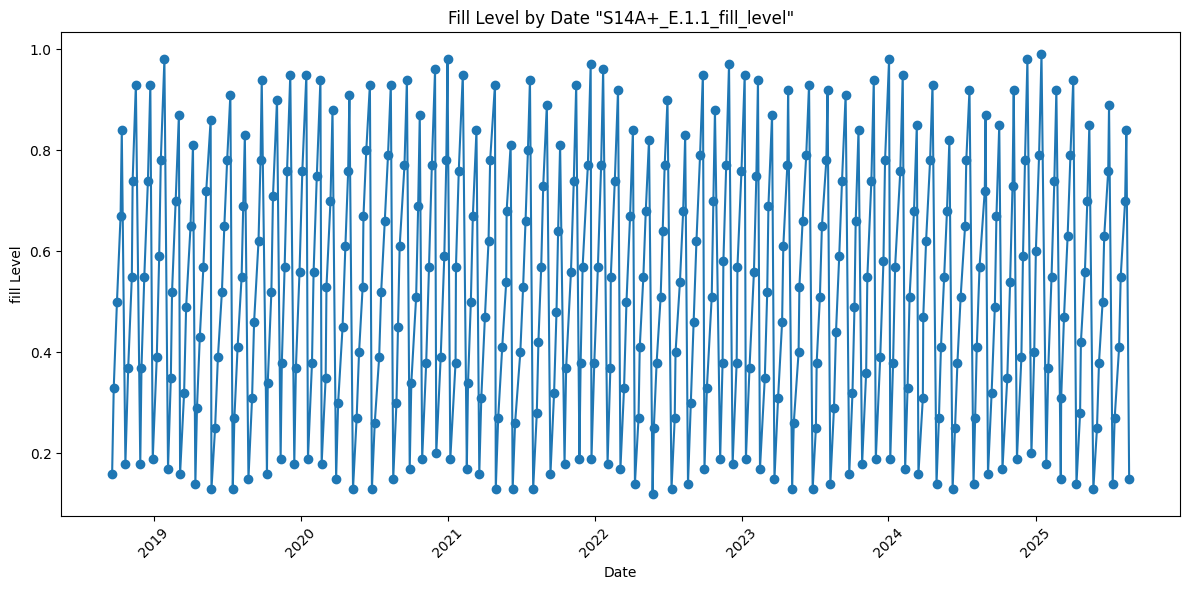

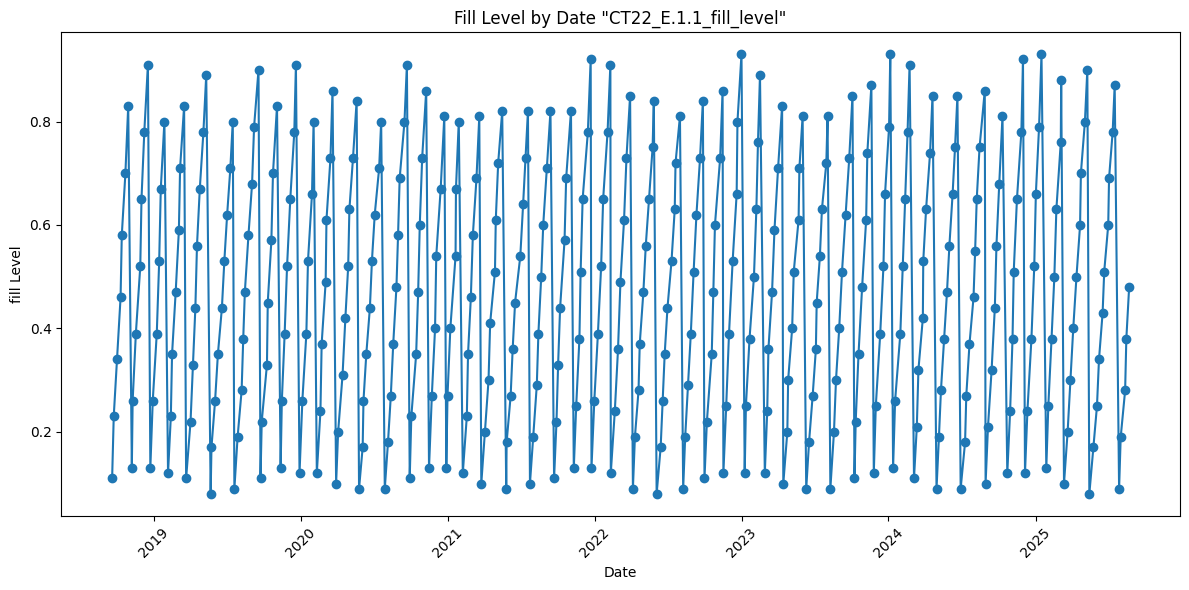

In [0]:
counter = 0 
for name in list(df_original.columns):
    if "fill_level" in name: 

        plt.figure(figsize=(12, 6))
        plt.plot(df_original['date'], df_original[name], marker='o', linestyle='-')
        plt.title(f'Fill Level by Date "{name}"')
        plt.xlabel('Date')
        plt.ylabel('fill Level')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
        plt.close()
        counter += 1
    if counter == 2: 
        break

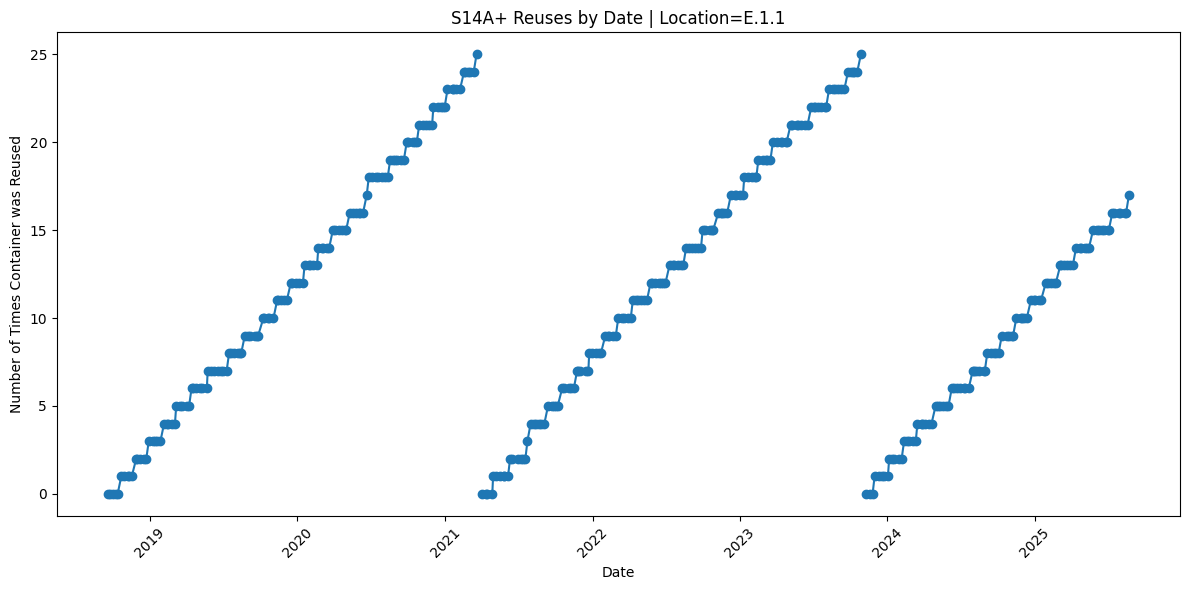

In [0]:
plt.figure(figsize=(12, 6))
plt.plot(df_original['date'], df_original['S14A+_E.1.1_reuses'], marker='o', linestyle='-')
plt.title('S14A+ Reuses by Date | Location=E.1.1')
plt.xlabel('Date')
plt.ylabel('Number of Times Container was Reused')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Let us now look at the spread each container and its associated location has been replaced due to reaching the max reusability. 

This will tell us the rate at which container and its associated location are serviced. 

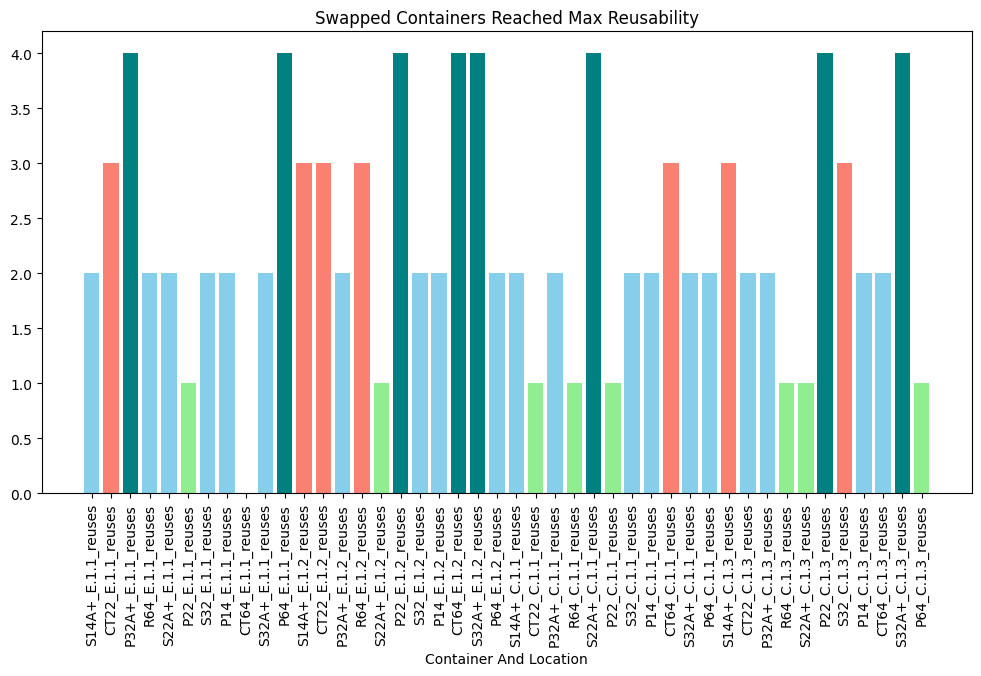

In [0]:
reuses_cols = [name for name in list(df_original.columns) if "reuses" in name]
y = df_original[reuses_cols].isna().sum().values

colors = []
for val in y:
    if val == 4:
        colors.append('teal')
    elif val == 3:
        colors.append('salmon')
    elif val == 2:
        colors.append('skyblue')
    else:
        colors.append('lightgreen')

plt.figure(figsize=(12, 6))
plt.bar(reuses_cols, y, color=colors)
plt.xticks(rotation=90)
plt.title('Swapped Containers Reached Max Reusability')
plt.xlabel('Container And Location')
plt.show()

In [0]:
df = df_original.copy()
print(df.shape)
df.head()

(363, 89)


,date,S14A+_E.1.1_fill_level,S14A+_E.1.1_reuses,CT22_E.1.1_fill_level,CT22_E.1.1_reuses,P32A+_E.1.1_fill_level,P32A+_E.1.1_reuses,R64_E.1.1_fill_level,R64_E.1.1_reuses,S22A+_E.1.1_fill_level,S22A+_E.1.1_reuses,P22_E.1.1_fill_level,P22_E.1.1_reuses,S32_E.1.1_fill_level,S32_E.1.1_reuses,P14_E.1.1_fill_level,P14_E.1.1_reuses,CT64_E.1.1_fill_level,CT64_E.1.1_reuses,S32A+_E.1.1_fill_level,S32A+_E.1.1_reuses,P64_E.1.1_fill_level,P64_E.1.1_reuses,S14A+_E.1.2_fill_level,S14A+_E.1.2_reuses,CT22_E.1.2_fill_level,CT22_E.1.2_reuses,P32A+_E.1.2_fill_level,P32A+_E.1.2_reuses,R64_E.1.2_fill_level,R64_E.1.2_reuses,S22A+_E.1.2_fill_level,S22A+_E.1.2_reuses,P22_E.1.2_fill_level,P22_E.1.2_reuses,S32_E.1.2_fill_level,S32_E.1.2_reuses,P14_E.1.2_fill_level,P14_E.1.2_reuses,CT64_E.1.2_fill_level,...,P32A+_C.1.1_fill_level,P32A+_C.1.1_reuses,R64_C.1.1_fill_level,R64_C.1.1_reuses,S22A+_C.1.1_fill_level,S22A+_C.1.1_reuses,P22_C.1.1_fill_level,P22_C.1.1_reuses,S32_C.1.1_fill_level,S32_C.1.1_reuses,P14_C.1.1_fill_level,P14_C.1.1_reuses,CT64_C.1.1_fill_level,CT64_C.1.1_reuses,S32A+_C.1.1_fill_level,S32A+_C.1.1_reuses,P64_C.1.1_fill_level,P64_C.1.1_reuses,S14A+_C.1.3_fill_level,S14A+_C.1.3_reuses,CT22_C.1.3_fill_level,CT22_C.1.3_reuses,P32A+_C.1.3_fill_level,P32A+_C.1.3_reuses,R64_C.1.3_fill_level,R64_C.1.3_reuses,S22A+_C.1.3_fill_level,S22A+_C.1.3_reuses,P22_C.1.3_fill_level,P22_C.1.3_reuses,S32_C.1.3_fill_level,S32_C.1.3_reuses,P14_C.1.3_fill_level,P14_C.1.3_reuses,CT64_C.1.3_fill_level,CT64_C.1.3_reuses,S32A+_C.1.3_fill_level,S32A+_C.1.3_reuses,P64_C.1.3_fill_level,P64_C.1.3_reuses
0,2018-09-18 15:41:39.633316,0.16,0.0,0.11,0.0,0.16,0.0,0.11,0.0,0.14,0.0,0.14,0.0,0.14,0.0,0.16,0.0,0.05,0.0,0.14,0.0,0.16,0.0,0.11,0.0,0.16,0.0,0.11,0.0,0.16,0.0,0.11,1.0,0.16,0.0,0.16,0.0,0.11,0.0,0.16,...,0.11,0.0,0.05,0.0,0.14,0.0,0.05,0.0,0.14,0.0,0.05,0.0,0.16,0.0,0.16,0.0,0.11,0.0,0.14,0.0,0.16,0.0,0.16,0.0,0.05,0.0,0.05,0.0,0.16,0.0,0.14,0.0,0.11,0.0,0.16,0.0,0.16,0.0,0.11,1.0
1,2018-09-22 15:41:39.633316,0.33,0.0,0.23,0.0,0.34,0.0,0.22,0.0,0.29,0.0,0.29,0.0,0.29,0.0,0.33,0.0,0.11,0.0,0.29,0.0,0.33,0.0,0.22,0.0,0.34,0.0,0.22,0.0,0.33,0.0,0.22,1.0,0.33,0.0,0.33,0.0,0.22,0.0,0.33,...,0.22,0.0,0.11,0.0,0.29,0.0,0.11,0.0,0.29,0.0,0.11,0.0,0.33,0.0,0.33,0.0,0.22,0.0,0.29,0.0,0.34,0.0,0.33,0.0,0.11,0.0,0.11,0.0,0.33,0.0,0.29,0.0,0.22,0.0,0.33,0.0,0.33,0.0,0.22,1.0
2,2018-09-30 15:41:39.633316,0.50,0.0,0.34,0.0,0.52,0.0,0.34,0.0,0.44,0.0,0.44,0.0,0.45,0.0,0.50,0.0,0.17,0.0,0.44,0.0,0.50,0.0,0.34,0.0,0.52,0.0,0.33,0.0,0.50,0.0,0.33,1.0,0.50,0.0,0.51,0.0,0.34,0.0,0.51,...,0.34,0.0,0.17,0.0,0.44,0.0,0.17,0.0,0.44,0.0,0.17,0.0,0.51,0.0,0.51,0.0,0.34,0.0,0.43,0.0,0.52,0.0,0.51,0.0,0.17,0.0,0.17,0.0,0.51,0.0,0.44,0.0,0.34,0.0,0.50,0.0,0.50,0.0,0.33,1.0
3,2018-10-09 15:41:39.633316,0.67,0.0,0.46,0.0,0.70,0.0,0.45,0.0,0.59,0.0,0.59,0.0,0.60,0.0,0.67,0.0,0.22,0.0,0.59,0.0,0.67,0.0,0.46,0.0,0.69,0.0,0.45,0.0,0.67,0.0,0.45,1.0,0.67,0.0,0.68,0.0,0.45,0.0,0.68,...,0.45,0.0,0.23,0.0,0.59,0.0,0.23,0.0,0.59,0.0,0.22,0.0,0.68,0.0,0.68,0.0,0.45,0.0,0.58,0.0,0.70,0.0,0.68,0.0,0.23,0.0,0.23,0.0,0.68,0.0,0.58,0.0,0.45,0.0,0.67,0.0,0.68,0.0,0.45,1.0
4,2018-10-12 15:41:39.633316,0.84,0.0,0.58,0.0,0.87,0.0,0.57,0.0,0.74,0.0,0.74,0.0,0.76,0.0,0.84,0.0,0.28,0.0,0.74,0.0,0.85,0.0,0.57,0.0,0.87,0.0,0.56,0.0,0.85,0.0,0.56,1.0,0.84,0.0,0.86,0.0,0.57,0.0,0.86,...,0.57,0.0,0.28,0.0,0.74,0.0,0.28,0.0,0.75,0.0,0.28,0.0,0.85,0.0,0.85,0.0,0.57,0.0,0.73,0.0,0.87,0.0,0.86,0.0,0.29,0.0,0.29,0.0,0.86,0.0,0.73,0.0,0.57,0.0,0.84,0.0,0.85,0.0,0.56,1.0


# Data Preprocessing

In [0]:
THRESHOLD = 0.80        # clean trigger
HORIZON_WEEKS = 2       # predict clean within next K weeks
LAGS = [1,2,3,4,5,6,7,8] # Fill levels from previous weeks
ROLLS = [3,6,12]         # Rolling window features over 3, 6, 12 weeks

df = df_original.copy()
df['date'] = pd.to_datetime(df['date'])

fill_cols = [c for c in df.columns if c.endswith('_fill_level')]
containers = [c.replace('_fill_level','') for c in fill_cols]

parts = []
for stem in containers:
    sub = df[['date', f'{stem}_fill_level', f'{stem}_reuses']].copy()
    sub.columns = ['date','fill_level','reuses']
    sub['container'] = stem
    parts.append(sub)

panel = (pd.concat(parts, ignore_index=True)
           .sort_values(['container','date'])
           .reset_index(drop=True))

def add_targets(g, horizon=HORIZON_WEEKS, threshold=THRESHOLD):
    g = g.sort_values('date').copy()
    # Rule: if fill >= threshold at t, a clean is *scheduled* at t+1
    g['should_clean_next_week'] = (g['fill_level'] >= threshold).astype(int)
    # Binary label: any clean in next K weeks?
    future = g.groupby(level=0, group_keys=False)
    g['clean_in_Kw'] = (g['should_clean_next_week']
                        .rolling(window=horizon, min_periods=1)
                        .max()
                        .shift(-1)  # look ahead from current week
                        .fillna(0)).astype(int)
    return g

panel = panel.groupby('container', group_keys=False).apply(add_targets)


In [0]:

# --- detect realized clean events from generator's reuse bumps
def add_events(g: pd.DataFrame) -> pd.DataFrame:
    g = g.sort_values('date').reset_index(drop=True)
    g['clean_this_week'] = (g['reuses'].diff().fillna(0) > 0).astype(int)
    # fallback if NaNs in reuses: schedule clean next week if threshold crossed
    if g['reuses'].isna().any():
        fallback = (g['fill_level'] >= THRESHOLD).shift(1, fill_value=False).astype(int)
        g.loc[g['reuses'].isna(), 'clean_this_week'] = fallback[g['reuses'].isna()]
    # compute weeks-until-next-clean (first future index with clean_this_week==1)
    next_clean_idx = []
    weeks_until = []
    for i in range(len(g)):
        after = g.index[(g.index > i) & (g['clean_this_week'] == 1)]
        if len(after):
            j = int(after[0])
            next_clean_idx.append(j)
            weeks_until.append(j - i)
        else:
            next_clean_idx.append(np.nan)
            weeks_until.append(np.nan)
    g['next_clean_idx'] = next_clean_idx
    g['weeks_until_clean'] = weeks_until
    return g

panel = panel.groupby('container', group_keys=False).apply(add_events).reset_index(drop=True)

In [0]:
def add_features(g):
    g = g.sort_values('date').copy()
    # time features
    g['weekofyear'] = g['date'].dt.isocalendar().week.astype(int)
    g['sin_woy'] = np.sin(2*np.pi*g['weekofyear']/52.0)
    g['cos_woy'] = np.cos(2*np.pi*g['weekofyear']/52.0)
    # lags & deltas
    for L in LAGS:
        g[f'lag_{L}'] = g['fill_level'].shift(L)
        g[f'delta_{L}'] = g['fill_level'] - g[f'lag_{L}']
    # rolling stats
    for W in ROLLS:
        g[f'roll_mean_{W}'] = g['fill_level'].rolling(W).mean()
        g[f'roll_std_{W}']  = g['fill_level'].rolling(W).std()
        g[f'roll_growth_{W}'] = g['fill_level'].diff().rolling(W).mean()
    # near threshold flag
    g['near_thresh'] = (g['fill_level'] >= 0.9*THRESHOLD).astype(int)
    # drop rows that would leak (need full history)
    feat_cols = [c for c in g.columns if c.startswith(('lag_','delta_','roll_'))] + \
                ['sin_woy','cos_woy','near_thresh','fill_level']
    g['features_ok'] = g[feat_cols].notna().all(axis=1)
    return g

panel = panel.groupby('container', group_keys=False).apply(add_features)



In [0]:
ml_df = panel[panel['features_ok']].copy()

display(panel[100:110])

date,fill_level,reuses,container,should_clean_next_week,clean_in_Kw,clean_this_week,next_clean_idx,weeks_until_clean,weekofyear,sin_woy,cos_woy,lag_1,delta_1,lag_2,delta_2,lag_3,delta_3,lag_4,delta_4,lag_5,delta_5,lag_6,delta_6,lag_7,delta_7,lag_8,delta_8,roll_mean_3,roll_std_3,roll_growth_3,roll_mean_6,roll_std_6,roll_growth_6,roll_mean_12,roll_std_12,roll_growth_12,near_thresh,features_ok
2020-08-17T15:41:39.633Z,0.09,8.0,CT22_C.1.1,0,0,0,113.0,13.0,34,-0.8229838658936564,-0.5680647467311559,0.04,0.049999999999999996,0.81,-0.7200000000000001,0.76,-0.67,0.71,-0.62,0.67,-0.5800000000000001,0.62,-0.53,0.57,-0.48,0.52,-0.43000000000000005,0.3133333333333334,0.4308518693627003,-0.2233333333333333,0.5133333333333333,0.35080858978460955,-0.08833333333333333,0.5066666666666667,0.2440690413995536,-0.020000000000000004,0,true
2020-08-25T15:41:39.633Z,0.14,8.0,CT22_C.1.1,0,0,0,113.0,12.0,35,-0.8854560256532096,-0.4647231720437691,0.09,0.05000000000000002,0.04,0.1,0.81,-0.67,0.76,-0.62,0.71,-0.57,0.67,-0.53,0.62,-0.48,0.57,-0.42999999999999994,0.09000000000000004,0.05000000000000066,-0.22333333333333336,0.425,0.36968905853433054,-0.08833333333333336,0.48666666666666664,0.2643803504365817,-0.02,0,true
2020-08-29T15:41:39.633Z,0.19,8.0,CT22_C.1.1,0,0,0,113.0,11.0,35,-0.8854560256532096,-0.4647231720437691,0.14,0.04999999999999999,0.09,0.1,0.04,0.15,0.81,-0.6200000000000001,0.76,-0.5700000000000001,0.71,-0.52,0.67,-0.48000000000000004,0.62,-0.43,0.14000000000000004,0.05000000000000057,0.049999999999999996,0.3383333333333334,0.34993808976255536,-0.08666666666666667,0.46666666666666673,0.27779434294041516,-0.02,0,true
2020-09-02T15:41:39.633Z,0.25,8.0,CT22_C.1.1,0,0,0,113.0,10.0,36,-0.9350162426854147,-0.3546048870425359,0.19,0.06,0.14,0.10999999999999999,0.09,0.16,0.04,0.21,0.81,-0.56,0.76,-0.51,0.71,-0.45999999999999996,0.67,-0.42000000000000004,0.19333333333333338,0.05507570547286145,0.05333333333333334,0.25333333333333335,0.28246533710646005,-0.08500000000000002,0.4475,0.2846409221202295,-0.019166666666666665,0,true
2020-09-14T15:41:39.633Z,0.3,8.0,CT22_C.1.1,0,0,0,113.0,9.0,38,-0.992708874098054,-0.12053668025532357,0.25,0.04999999999999999,0.19,0.10999999999999999,0.14,0.15999999999999998,0.09,0.21,0.04,0.26,0.81,-0.51,0.76,-0.46,0.71,-0.41,0.2466666666666667,0.055075705472861364,0.05333333333333332,0.16833333333333333,0.09786044485217707,-0.08500000000000002,0.42916666666666664,0.2866248207653829,-0.018333333333333337,0,true
2020-09-20T15:41:39.633Z,0.36,8.0,CT22_C.1.1,0,0,0,113.0,8.0,38,-0.992708874098054,-0.12053668025532357,0.3,0.06,0.25,0.10999999999999999,0.19,0.16999999999999998,0.14,0.21999999999999997,0.09,0.27,0.04,0.32,0.81,-0.45000000000000007,0.76,-0.4,0.30333333333333334,0.055075705472861274,0.056666666666666664,0.22166666666666668,0.10107752800037237,0.053333333333333316,0.4116666666666667,0.28363976299439253,-0.017499999999999998,0,true
2020-09-27T15:41:39.633Z,0.42,8.0,CT22_C.1.1,0,0,0,113.0,7.0,39,-1.0,-1.8369701987210297E-16,0.36,0.06,0.3,0.12,0.25,0.16999999999999998,0.19,0.22999999999999998,0.14,0.27999999999999997,0.09,0.32999999999999996,0.04,0.38,0.81,-0.39000000000000007,0.36000000000000004,0.06000000000000015,0.056666666666666664,0.27666666666666667,0.10481730137084302,0.054999999999999986,0.395,0.27605994079020396,-0.016666666666666666,0,true
2020-10-01T15:41:39.633Z,0.48,8.0,CT22_C.1.1,0,0,0,113.0,6.0,40,-0.992708874098054,0.1205366802553232,0.42,0.06,0.36,0.12,0.3,0.18,0.25,0.22999999999999998,0.19,0.29,0.14,0.33999999999999997,0.09,0.39,0.04,0.44,0.42,0.06000000000000007,0.06,0.3333333333333333,0.10801234497346221,0.05666666666666664,0.37916666666666665,0.26404057309895435,-0.015833333333333338,0,true
2020-10-13T15:41:39.633Z,0.54,8.0,CT22_C.1.1,0,0,0,113.0,5.0,42,-0.9350162426854148,0.35460488704253557,0.48,0.06000000000000005,0.42,0.12000000000000005,0.36,0.18000000000000005,0.3,0.24000000000000005,0.25,0.29000000000000004,0.19,0.35000000000000003,0.14,0.4,0.09,0.45000000000000007,0.48,0.0600000000000000

## Save ML Dataset to table with Spark

In [0]:
# suppose ml_df are pandas
ml_sdf          = spark.createDataFrame(ml_df)          # features + label for classifier


In [0]:
catalog = "workspace"          # or your UC catalog
schema  = "ml"            # create if needed: spark.sql("CREATE SCHEMA IF NOT EXISTS main.ml")
spark.sql(
  f"CREATE SCHEMA IF NOT EXISTS {catalog}.{schema}"
)

ml_table      = f"{catalog}.{schema}.bin_cleaning_ml"

(ml_sdf
  .write
  .format("delta")
  .mode("overwrite")
  .option("overwriteSchema", "true")
  .saveAsTable(ml_table))


In [0]:
v = spark.sql(f"DESCRIBE HISTORY {ml_table}").toPandas().iloc[0]['version']
print("Delta version saved:", v)


Delta version saved: 3
